## Setup

In [1]:
from tectosaur2.nb_config import setup

setup()


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

from tectosaur2 import integrate_term, refine_surfaces, gauss_rule, trapezoidal_rule
from tectosaur2.mesh import concat_meshes
from tectosaur2.laplace2d import single_layer, double_layer

In [29]:
nq = 10
qx, qw = gauss_rule(nq)

t = sp.symbols("t")
t01 = (t + 1) / 2
# counter-clockwise from the bottom left
bottom, right, top, left = refine_surfaces(
    [
        (t, t01, 0),
        (t, 1, t01),
        (t, 1 - t01, 1),
        (t, 0, 1 - t01)
    ],
    (qx,qw),
    control_points=np.array([[0,0,2,0.2]])
)
box = concat_meshes((bottom, right, top, left))
box.n_panels, box.n_pts

(32, 320)

## Body force quadrature

In [56]:
nq_volume = 40
q_vol, qw_vol = gauss_rule(nq_volume)
q_vol = (q_vol + 1) / 2
qw_vol /= 2

qx_vol, qy_vol = np.meshgrid(q_vol, q_vol)
q2d_vol = np.array([qx_vol.flatten(), qy_vol.flatten()]).T.copy()
q2d_vol_wts = (qw_vol[:, None] * qw_vol[None, :]).flatten()

In [57]:
np.sum(q2d_vol_wts)

1.0000000000000002

In [58]:
correct = 0.9460830703671830
correct - np.sum(np.cos(q2d_vol[:,0] * q2d_vol[:,1]) * q2d_vol_wts)

-3.3306690738754696e-16

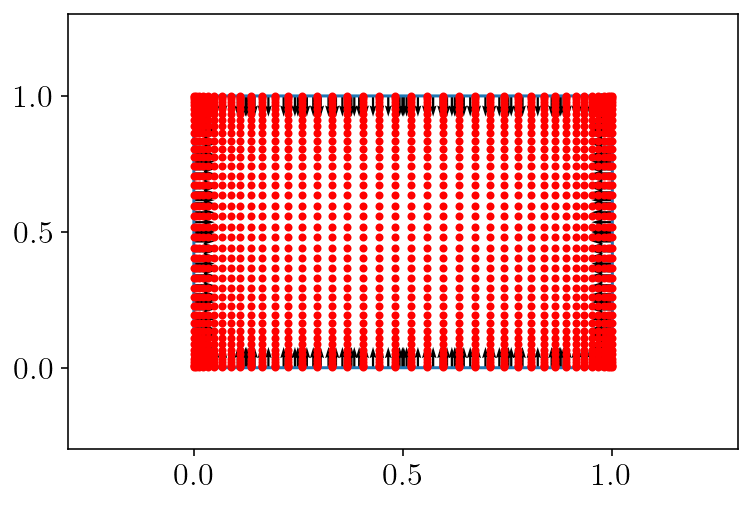

In [59]:
plt.plot(box.pts[:, 0], box.pts[:, 1])
plt.quiver(box.pts[:, 0], box.pts[:, 1], box.normals[:, 0], box.normals[:, 1])
plt.plot(q2d_vol[:, 0], q2d_vol[:, 1], "r.")
plt.xlim([-0.3, 1.3])
plt.ylim([-0.3, 1.3])
plt.show()

In [60]:
nobs = 200
offset = 0
zoomx = [offset, 1.0 - offset]
zoomy = [offset, 1.0 - offset]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obsx, obsy = np.meshgrid(xs, ys)
obs2d = np.array([obsx.flatten(), obsy.flatten()]).T.copy()

In [106]:
freq_factor = 1.0
def soln_fnc(x, y):
    return np.sin(freq_factor * 2 * np.pi * x) * np.sin(freq_factor * 2 * np.pi * y)

def laplacian_fnc(x, y):
    return (
        -(2 * ((2 * freq_factor) ** 2))
        * np.pi ** 2
        * np.sin(freq_factor * 2 * np.pi * x)
        * np.sin(freq_factor * 2 * np.pi * y)
    )

# Ae = 5
# def soln_fnc(x, y):
#     return np.exp(-((x - 0.5) ** 2 + (y - 0.5) ** 2) * Ae)

# def laplacian_fnc(x, y):
#     return 4 * Ae * soln_fnc(x, y) * (Ae * ((x - 0.5) ** 2 + (y - 0.5) ** 2) - 1)

In [107]:
fxy = -laplacian_fnc(q2d_vol[:,0], q2d_vol[:,1])
correct = soln_fnc(obsx, obsy)
fxy_obs = -laplacian_fnc(obsx, obsy)

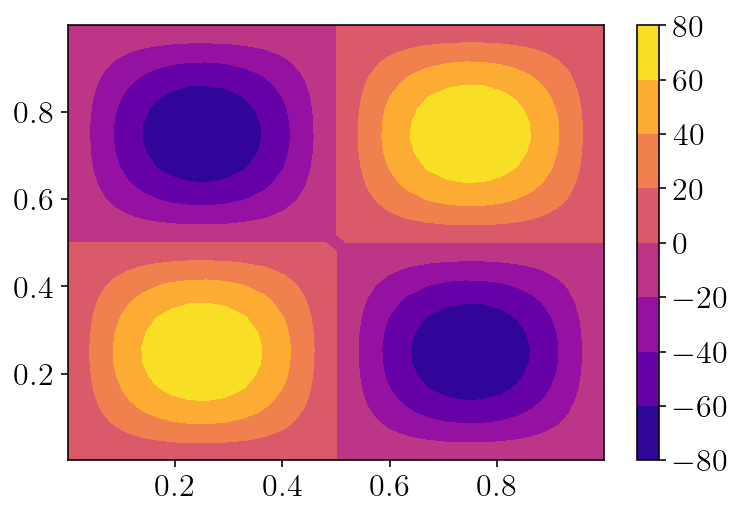

In [108]:
plt.contourf(qx_vol, qy_vol, fxy.reshape(qx_vol.shape))
plt.colorbar()
plt.show()

In [109]:
hx = xs[1] - xs[0]
hy = ys[1] - ys[0]
hx, hy

(0.005025125628140704, 0.005025125628140704)

In [110]:
dx2 = (correct[2:] - 2*correct[1:-1] + correct[:-2]) / (hx ** 2)
dy2 = (correct[:, 2:] - 2*correct[:, 1:-1] + correct[:, :-2]) / (hy ** 2)

In [111]:
neg_laplacian = np.zeros_like(fxy_obs)
neg_laplacian[1:-1] -= dx2
neg_laplacian[:,1:-1] -= dy2

/var/folders/mt/cmys2v_143q1kpcrdt5wcdyr0000gn/T/ipykernel_10293/2017794197.py:31: RuntimeWarning: divide by zero encountered in log10
  err = np.log10(np.abs(neg_laplacian - fxy_obs))


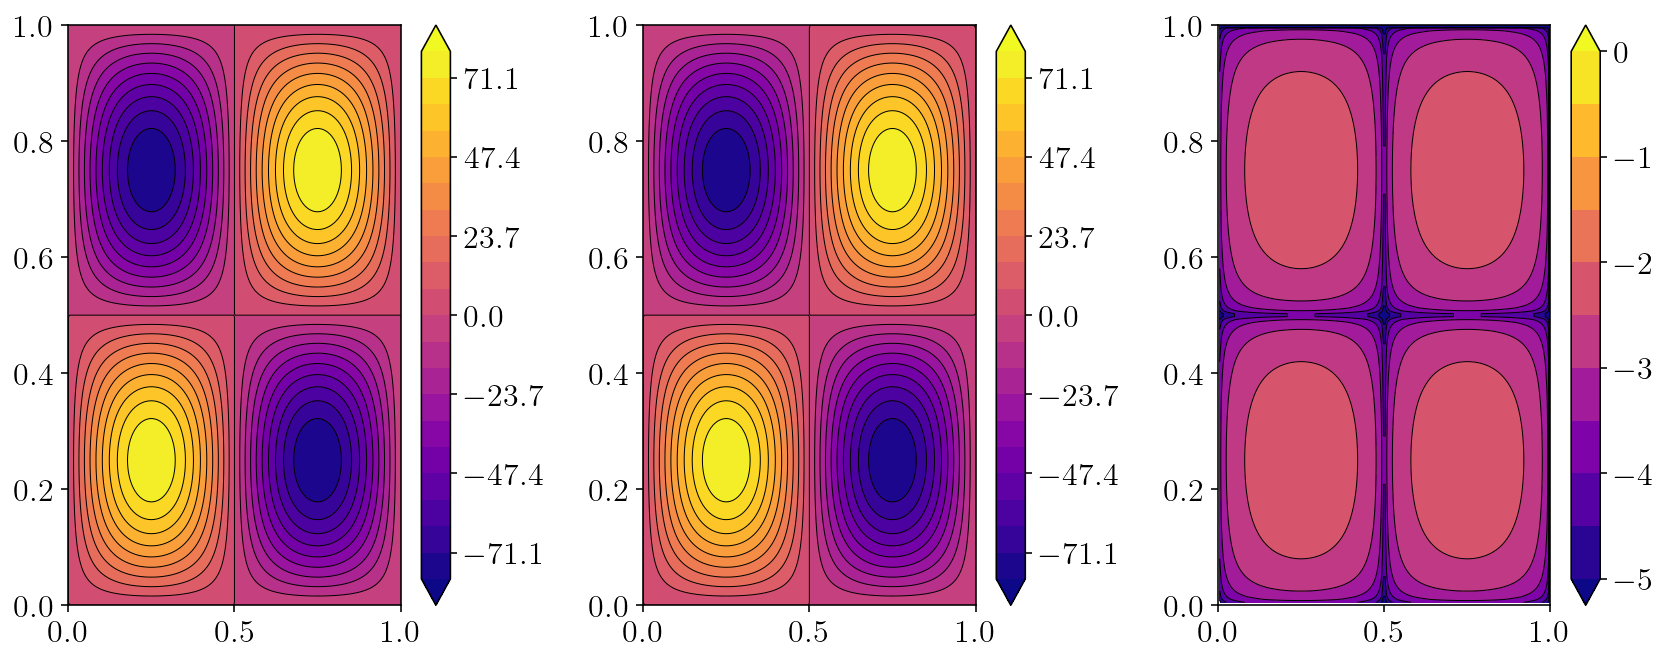

In [112]:
plt.figure(figsize = (12,5))
plt.subplot(1,3,1)
levels = np.linspace(np.min(fxy_obs), np.max(fxy_obs), 21)
cntf = plt.contourf(obsx, obsy, fxy_obs, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    fxy_obs,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.subplot(1,3,2)
levels = np.linspace(np.min(neg_laplacian), np.max(neg_laplacian), 21)
cntf = plt.contourf(obsx, obsy, neg_laplacian, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    neg_laplacian,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.subplot(1,3,3)
err = np.log10(np.abs(neg_laplacian - fxy_obs))
levels = np.linspace(-5, 0, 11)
cntf = plt.contourf(obsx, obsy, err, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    err,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.tight_layout()
plt.show()

In [113]:
u_particular = (
    (single_layer.kernel(obs2d, q2d_vol, 0*q2d_vol)[:,0,:,0] * q2d_vol_wts[None,:])
    .dot(fxy)
    .reshape(obsx.shape)
)

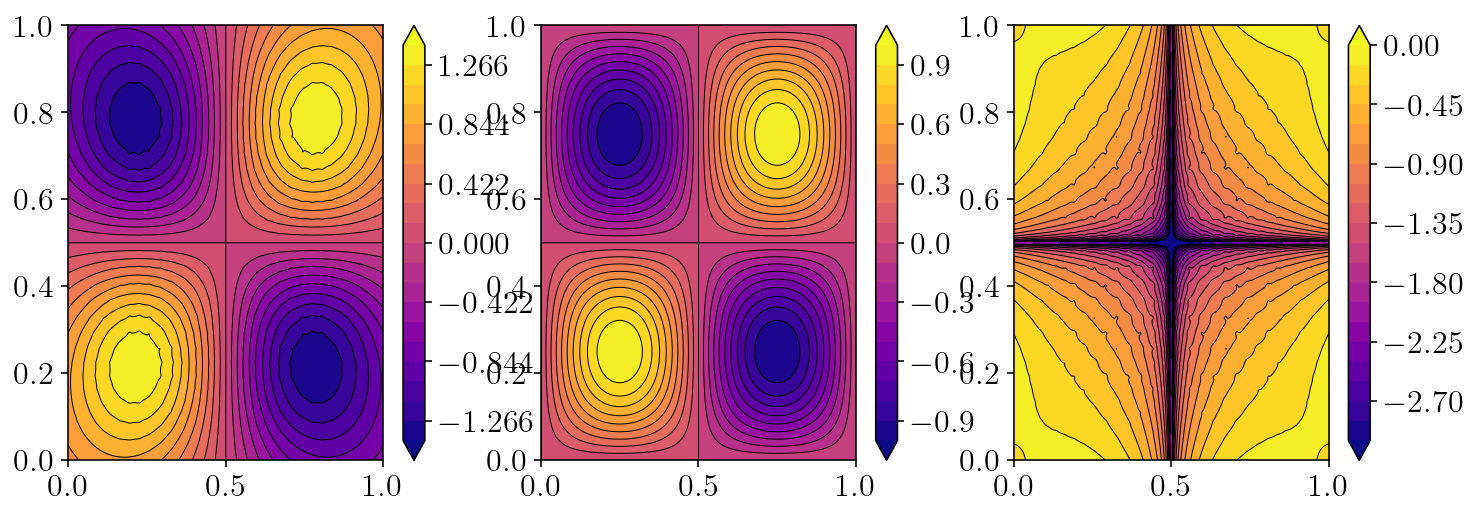

In [114]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
levels = np.linspace(np.min(u_particular), np.max(u_particular), 21)
cntf = plt.contourf(obsx, obsy, u_particular, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    u_particular,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.subplot(1,3,2)
levels = np.linspace(np.min(correct), np.max(correct), 21)
cntf = plt.contourf(obsx, obsy, correct, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    correct,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.subplot(1,3,3)
err = np.log10(np.abs(u_particular - correct))
levels = np.linspace(-3, 0, 21)
cntf = plt.contourf(obsx, obsy, err, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    err,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.show()

## Direct to surface eval

In [115]:
## This is g
bcs = soln_fnc(box.pts[:, 0], box.pts[:, 1])
## This is v|_{\partial \Omega}
surf_vals = (single_layer.kernel(box.pts, q2d_vol)[:,0,:,0] * q2d_vol_wts[None,:]).dot(fxy)
A,report = integrate_term(double_layer, box.pts, box, safety_mode=True, return_report=True)
surf_density = np.linalg.solve(-A[:,0,:,0], bcs-surf_vals)

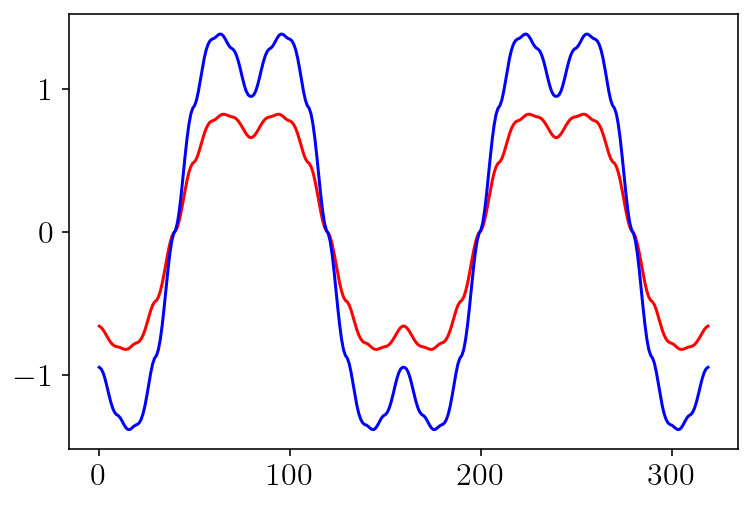

In [116]:
plt.plot(bcs-surf_vals, 'r-')
plt.plot(surf_density, 'b-')
plt.show()

In [125]:
%%time
interior_disp_mat = integrate_term(double_layer, obs2d, box, safety_mode=True, tol=1e-13)
u_homog = -interior_disp_mat[:, 0, :, 0].dot(surf_density).reshape(obsx.shape)

CPU times: user 2.26 s, sys: 272 ms, total: 2.53 s
Wall time: 543 ms


## Full solution!

In [126]:
u_full = u_homog + u_particular
#u_full = u_box_rough + u_body_force

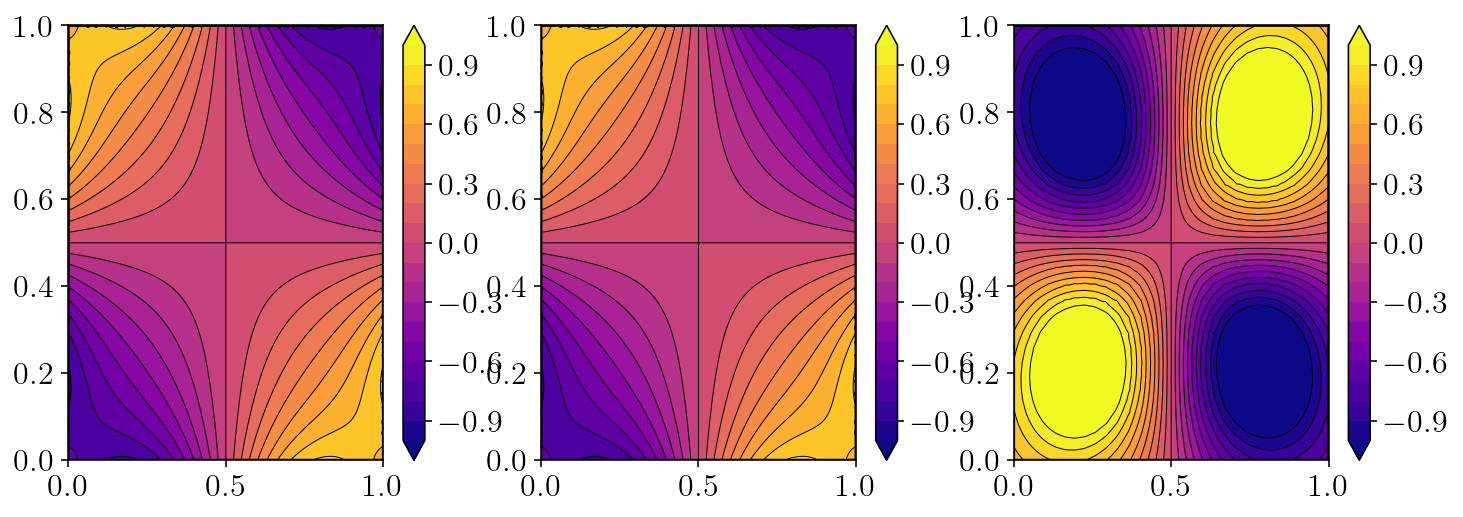

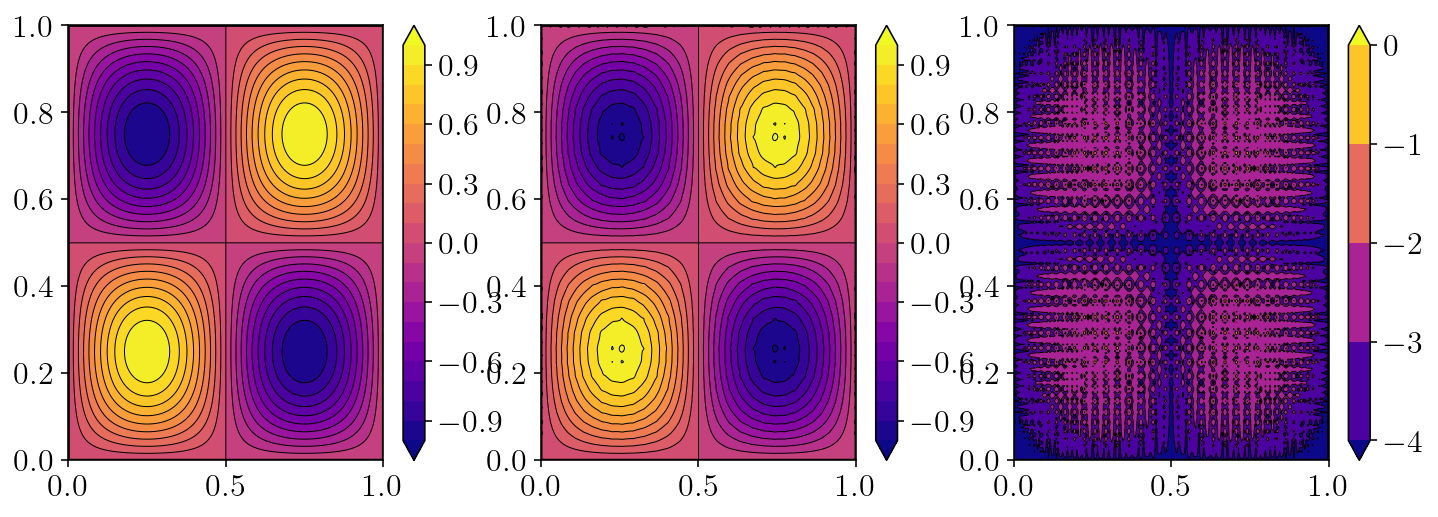

In [129]:
# levels = np.linspace(np.min(u_full), np.max(u_full), 21)
plt.figure(figsize=(12,4))
for i, to_plot in enumerate([u_homog, u_homog, u_particular]):
    plt.subplot(1,3,1+i)
    levels = np.linspace(-1, 1, 21)
    cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        to_plot,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.plot(box.pts[:, 0], box.pts[:, 1], "k-", linewidth=1.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

plt.figure(figsize=(12,4))
for i, to_plot in enumerate([correct, u_full]):
    plt.subplot(1,3,1+i)
    levels = np.linspace(-1, 1, 21)
    cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
    plt.contour(
        obsx,
        obsy,
        to_plot,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.plot(box.pts[:, 0], box.pts[:, 1], "k-", linewidth=1.5)
    plt.colorbar(cntf)
    plt.xlim(zoomx)
    plt.ylim(zoomy)

plt.subplot(1,3,3)
to_plot = np.log10(np.abs(correct - u_full))
levels = np.linspace(-4, 0, 5)
cntf = plt.contourf(obsx, obsy, to_plot, levels=levels, extend="both")
plt.contour(
    obsx,
    obsy,
    to_plot,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.plot(box.pts[:, 0], box.pts[:, 1], "k-", linewidth=1.5)
plt.colorbar(cntf)
plt.xlim(zoomx)
plt.ylim(zoomy)
plt.show()